In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=542902b668b404a5f3a5fcffcbfcd3138a300761f1dffa5d4060c4479bdcdda0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=72fd9a26ca4621e951ecf3eec816b8d105960d04327e11cacd5667363721e8ac
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import random
import os
import matplotlib.pylab as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import segmentation_models_pytorch as smp

In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = path = '/kaggle/working/' 
MODEL_PATH = '/kaggle/input/unet_mobilenetv2/pytorch/400epochs/1/model (2).pt'
TRAIN_IMG_PATH = '/kaggle/input/ct-scans-ds/train_ds/original_png'
TRAIN_MASK_PATH = '/kaggle/input/ct-scans-ds/train_ds/mask_png'
TEST_IMG_PATH = '/kaggle/input/ct-scans-ds/test_ds/test/original_png'
TEST_MASK_PATH = '/kaggle/input/ct-scans-ds/test_ds/test/mask_png'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
LEARNING_RATE = 1e-4
NUM_EPOCHS = 300
BATCH_SIZE = 16
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = True


In [4]:
DEVICE

device(type='cuda')

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64,128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
    
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape)
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
    
        return self.final_conv(x)
        

In [6]:
class CTDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.image_path))

    def __getitem__(self, index):
        img_name = f'{index}.png'
        img_path = os.path.join(self.image_path, img_name)
        mask_path = os.path.join(self.mask_path, img_name)  # Assuming mask files have the same name as image files with "_mask" suffix

        image = np.array(Image.open(img_path).convert("L"), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0
        image = image / 255.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [94]:
train_transform = A.Compose(
    [
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.25),
#         A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2()
    ]
)                                           

In [8]:
def save_checkpoint(state, path=PATH, filename="model.pt"):
    print("=> Saving checkpoint")
    torch.save(state, path + filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_path, train_mask_path, val_path, val_mask_path, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True):
    train_ds = CTDataset(image_path=train_path, mask_path=train_mask_path, transform=train_transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, pin_memory=pin_memory, shuffle=True)
    val_ds = CTDataset(image_path=val_path, mask_path=val_mask_path, transform=val_transform)
    val_loader = DataLoader(val_ds, batch_size=batch_size,pin_memory=pin_memory, shuffle=False)
    return train_loader, val_loader

def check_accuracy(loader, model, history_val, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    recall = 0
    iou = 0
    precision = 0
    accuracy = 0
    model.eval()

    with torch.no_grad():
        for x,y in tqdm(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            TP = ((y == 1) * (preds == 1)).sum()
            FP = ((y == 0) * (preds == 1)).sum()
            FN = ((y == 1) * (preds == 0)).sum()
            TN = ((y == 0) * (preds == 0)).sum()
            
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum() + 1e-8) / ((preds + y).sum() + 1e-8)
            precision += ((TP + 1e-8) / (TP + FP + 1e-8))
            recall += ((TP + 1e-8) / (TP + FN + 1e-8))
            iou += ((TP + 1e-8) / (TP + FP + FN + 1e-8))

    history_val['val_dice_coe'].append(dice_score/(len(loader)))
    history_val['val_precision'].append(precision/(len(loader)))
    history_val['val_recall'].append(recall/(len(loader)))
    history_val['val_iou'].append(iou/(len(loader)))
    
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)} ")
    model.train()

def save_predicts_as_imgs(loader, model, folder='saved_images\\', device="cuda"):
    model.eval()
    for idx, (x,y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{PATH + folder}pred_{idx}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{PATH + folder}{idx}.png")

    model.train()

In [72]:
def train_fn(loader, model, optimizer, loss_fn, scaler, history_val):
    loop = tqdm(loader)
    dice_score = 0
    iou = 0
    precision = 0
    recall = 0
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        
        predictions = model(data)
        preds = torch.sigmoid(predictions)
        preds = (preds > 0.5).float()
        
        TP = ((preds == 1) * (targets == 1)).sum()
        FP = ((preds == 1) * (targets == 0)).sum()
        FN = ((preds == 0) * (targets == 1)).sum()
        TN = ((preds == 0) * (targets == 0)).sum()
        
        
        dice_score += (2 * (preds * targets).sum() + 1e-8) / ((preds + targets).sum() + 1e-8)
        precision += ((TP + 1e-8) / (TP + FP + 1e-8))
        recall += ((TP + 1e-8) / (TP + FN + 1e-8))
        iou += ((TP + 1e-8) / (TP + FP + FN + 1e-8))
        
        
        loss = loss_fn(predictions, targets)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        
    history_val['train_precision'].append(precision/(len(loader)))
    history_val['train_recall'].append(recall/(len(loader)))
    history_val['train_iou'].append(iou/(len(loader)))
    history_val['train_dice_coe'].append(dice_score/(len(loader)))
    

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predicted, target):
        intersection = (predicted * target).sum()
        union = predicted.sum() + target.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

In [117]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        

    def forward(self, inputs, targets, smooth=1e-8):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        weight_factor = 2.0  # You can adjust this factor according to your requirement
        weight = targets * weight_factor + (1 - targets)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = nn.functional.binary_cross_entropy(inputs, targets, reduction='mean',weight=weight)
        Dice_BCE = BCE + dice_loss
#         print(BCE, dice_loss)
        return Dice_BCE

In [40]:
ALPHA = 0.8
GAMMA = 2
    
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma=GAMMA):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = nn.functional.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha=ALPHA, gamma=GAMMA):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [106]:
# model = UNET(in_channels=1, out_channels=1).to(device=DEVICE)
model = smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
#     activation='sigmoid',
).to(device=DEVICE)

In [118]:
loss_fn = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [95]:
train_loader, val_loader = get_loaders(
    TRAIN_IMG_PATH,
    TRAIN_MASK_PATH,
    TEST_IMG_PATH,
    TEST_MASK_PATH,
    BATCH_SIZE,
    train_transform,
    val_transform
)

In [124]:
if LOAD_MODEL:
    load_checkpoint(torch.load(MODEL_PATH), model)

=> Loading checkpoint


In [125]:
# history_val = {'train_dice_coe':[], 'val_dice_coe':[], 'train_recall':[], 'train_precision':[], 'train_iou':[], 'val_precision':[], 'val_recall': [], 'val_iou': []}

check_accuracy(val_loader, model, history_val, device=DEVICE)

scaler = None
for epoch in range(100):
    train_fn(train_loader, model, optimizer, loss_fn, scaler, history_val)
    
    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
#     save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, history_val, device=DEVICE)

    #print some examples to a folder
#     save_predicts_as_imgs(val_loader, model, folder="saved_images\\", device=DEVICE)

100%|██████████| 17/17 [00:02<00:00,  8.03it/s]


Got 17291234/17301504 with acc 99.94
Dice score: 0.44014105200767517 


100%|██████████| 17/17 [00:02<00:00,  8.21it/s]


Got 17291165/17301504 with acc 99.94
Dice score: 0.44090718030929565 


100%|██████████| 17/17 [00:02<00:00,  8.39it/s]


Got 17291445/17301504 with acc 99.94
Dice score: 0.4542146921157837 


100%|██████████| 17/17 [00:02<00:00,  8.26it/s]


Got 17291396/17301504 with acc 99.94
Dice score: 0.4521952271461487 


100%|██████████| 17/17 [00:02<00:00,  7.74it/s]


Got 17291338/17301504 with acc 99.94
Dice score: 0.4452453553676605 


100%|██████████| 17/17 [00:02<00:00,  8.36it/s]


Got 17291379/17301504 with acc 99.94
Dice score: 0.45293307304382324 


100%|██████████| 17/17 [00:02<00:00,  7.86it/s]


Got 17291371/17301504 with acc 99.94
Dice score: 0.4458872377872467 


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


Got 17291280/17301504 with acc 99.94
Dice score: 0.44770535826683044 


100%|██████████| 17/17 [00:02<00:00,  7.87it/s]


Got 17291432/17301504 with acc 99.94
Dice score: 0.44704967737197876 


100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


Got 17291281/17301504 with acc 99.94
Dice score: 0.4446476101875305 


100%|██████████| 17/17 [00:02<00:00,  8.46it/s]


Got 17291374/17301504 with acc 99.94
Dice score: 0.441632479429245 


100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


Got 17291361/17301504 with acc 99.94
Dice score: 0.44501760601997375 


100%|██████████| 17/17 [00:02<00:00,  8.25it/s]


Got 17291402/17301504 with acc 99.94
Dice score: 0.4469340443611145 


100%|██████████| 17/17 [00:02<00:00,  8.38it/s]


Got 17291243/17301504 with acc 99.94
Dice score: 0.43826913833618164 


100%|██████████| 17/17 [00:02<00:00,  8.45it/s]


Got 17291423/17301504 with acc 99.94
Dice score: 0.4508386552333832 


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


Got 17291371/17301504 with acc 99.94
Dice score: 0.4494608938694 


100%|██████████| 17/17 [00:02<00:00,  8.36it/s]


Got 17291424/17301504 with acc 99.94
Dice score: 0.4496493935585022 


100%|██████████| 17/17 [00:02<00:00,  8.24it/s]


Got 17291388/17301504 with acc 99.94
Dice score: 0.4432501196861267 


100%|██████████| 17/17 [00:02<00:00,  8.30it/s]


Got 17291374/17301504 with acc 99.94
Dice score: 0.4477154016494751 


100%|██████████| 17/17 [00:02<00:00,  8.36it/s]


Got 17291280/17301504 with acc 99.94
Dice score: 0.44105294346809387 


100%|██████████| 17/17 [00:02<00:00,  7.91it/s]


Got 17291427/17301504 with acc 99.94
Dice score: 0.4454483985900879 


100%|██████████| 17/17 [00:02<00:00,  8.32it/s]


Got 17291492/17301504 with acc 99.94
Dice score: 0.4482920467853546 


100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


Got 17291362/17301504 with acc 99.94
Dice score: 0.4444974362850189 


100%|██████████| 17/17 [00:02<00:00,  8.34it/s]


Got 17291329/17301504 with acc 99.94
Dice score: 0.44836869835853577 


100%|██████████| 17/17 [00:02<00:00,  8.12it/s]


Got 17291279/17301504 with acc 99.94
Dice score: 0.4394752085208893 


100%|██████████| 17/17 [00:02<00:00,  8.18it/s]


Got 17291499/17301504 with acc 99.94
Dice score: 0.4499637484550476 


100%|██████████| 17/17 [00:02<00:00,  8.37it/s]


Got 17291229/17301504 with acc 99.94
Dice score: 0.4430287182331085 


100%|██████████| 17/17 [00:02<00:00,  8.43it/s]


Got 17291247/17301504 with acc 99.94
Dice score: 0.4433104991912842 


100%|██████████| 17/17 [00:02<00:00,  8.37it/s]


Got 17291479/17301504 with acc 99.94
Dice score: 0.449554443359375 


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


Got 17291416/17301504 with acc 99.94
Dice score: 0.4487723708152771 


100%|██████████| 17/17 [00:02<00:00,  8.41it/s]


Got 17291412/17301504 with acc 99.94
Dice score: 0.4455420672893524 


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17291315/17301504 with acc 99.94
Dice score: 0.44421717524528503 


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17291390/17301504 with acc 99.94
Dice score: 0.44669848680496216 


100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


Got 17291408/17301504 with acc 99.94
Dice score: 0.4474093019962311 


100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


Got 17291352/17301504 with acc 99.94
Dice score: 0.44846639037132263 


100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Got 17291488/17301504 with acc 99.94
Dice score: 0.4528026580810547 


100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Got 17291236/17301504 with acc 99.94
Dice score: 0.44488680362701416 


100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


Got 17291349/17301504 with acc 99.94
Dice score: 0.44138872623443604 


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


Got 17291427/17301504 with acc 99.94
Dice score: 0.4480154514312744 


100%|██████████| 17/17 [00:02<00:00,  8.29it/s]


Got 17291312/17301504 with acc 99.94
Dice score: 0.4466858208179474 


100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


Got 17291288/17301504 with acc 99.94
Dice score: 0.4432260990142822 


100%|██████████| 17/17 [00:02<00:00,  7.91it/s]


Got 17291354/17301504 with acc 99.94
Dice score: 0.4475135803222656 


100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


Got 17291370/17301504 with acc 99.94
Dice score: 0.44783350825309753 


100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


Got 17291432/17301504 with acc 99.94
Dice score: 0.45087435841560364 


100%|██████████| 17/17 [00:02<00:00,  8.26it/s]


Got 17291275/17301504 with acc 99.94
Dice score: 0.44717854261398315 


100%|██████████| 17/17 [00:02<00:00,  8.36it/s]


Got 17291362/17301504 with acc 99.94
Dice score: 0.45145803689956665 


100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


Got 17291176/17301504 with acc 99.94
Dice score: 0.44344380497932434 


100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


Got 17291182/17301504 with acc 99.94
Dice score: 0.43989279866218567 


100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


Got 17291393/17301504 with acc 99.94
Dice score: 0.4460286498069763 


100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Got 17291444/17301504 with acc 99.94
Dice score: 0.4485311806201935 


100%|██████████| 17/17 [00:02<00:00,  8.31it/s]


Got 17291391/17301504 with acc 99.94
Dice score: 0.44864407181739807 


100%|██████████| 17/17 [00:02<00:00,  7.67it/s]


Got 17291463/17301504 with acc 99.94
Dice score: 0.4460805654525757 


100%|██████████| 17/17 [00:02<00:00,  8.31it/s]


Got 17291254/17301504 with acc 99.94
Dice score: 0.4438577890396118 


100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


Got 17291200/17301504 with acc 99.94
Dice score: 0.44086411595344543 


100%|██████████| 17/17 [00:02<00:00,  8.10it/s]


Got 17291343/17301504 with acc 99.94
Dice score: 0.4507528841495514 


100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


Got 17291310/17301504 with acc 99.94
Dice score: 0.44067826867103577 


100%|██████████| 17/17 [00:02<00:00,  8.11it/s]


Got 17291396/17301504 with acc 99.94
Dice score: 0.45122164487838745 


100%|██████████| 17/17 [00:02<00:00,  7.79it/s]


Got 17291390/17301504 with acc 99.94
Dice score: 0.44389089941978455 


100%|██████████| 17/17 [00:02<00:00,  8.14it/s]


Got 17291412/17301504 with acc 99.94
Dice score: 0.44312554597854614 


100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Got 17291378/17301504 with acc 99.94
Dice score: 0.4515564739704132 


100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


Got 17291401/17301504 with acc 99.94
Dice score: 0.4473489224910736 


100%|██████████| 17/17 [00:02<00:00,  8.16it/s]


Got 17291439/17301504 with acc 99.94
Dice score: 0.4497069716453552 


100%|██████████| 17/17 [00:02<00:00,  7.66it/s]


Got 17291447/17301504 with acc 99.94
Dice score: 0.44595497846603394 


100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


Got 17291340/17301504 with acc 99.94
Dice score: 0.44160690903663635 


100%|██████████| 17/17 [00:02<00:00,  7.82it/s]


Got 17291384/17301504 with acc 99.94
Dice score: 0.448691189289093 


100%|██████████| 17/17 [00:02<00:00,  7.74it/s]


Got 17291470/17301504 with acc 99.94
Dice score: 0.4493701756000519 


100%|██████████| 17/17 [00:02<00:00,  7.64it/s]


Got 17291380/17301504 with acc 99.94
Dice score: 0.4467046558856964 


100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


Got 17291282/17301504 with acc 99.94
Dice score: 0.44562047719955444 


100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


Got 17291306/17301504 with acc 99.94
Dice score: 0.4458366632461548 


100%|██████████| 17/17 [00:02<00:00,  7.93it/s]


Got 17291220/17301504 with acc 99.94
Dice score: 0.4426771104335785 


100%|██████████| 17/17 [00:02<00:00,  7.74it/s]


Got 17291343/17301504 with acc 99.94
Dice score: 0.44866982102394104 


100%|██████████| 17/17 [00:02<00:00,  7.97it/s]


Got 17291204/17301504 with acc 99.94
Dice score: 0.44684135913848877 


100%|██████████| 17/17 [00:02<00:00,  7.87it/s]


Got 17291322/17301504 with acc 99.94
Dice score: 0.4464292526245117 


100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


Got 17291329/17301504 with acc 99.94
Dice score: 0.4467536211013794 


100%|██████████| 17/17 [00:02<00:00,  7.58it/s]


Got 17291483/17301504 with acc 99.94
Dice score: 0.45023179054260254 


100%|██████████| 17/17 [00:02<00:00,  7.87it/s]


Got 17291567/17301504 with acc 99.94
Dice score: 0.45407071709632874 


100%|██████████| 17/17 [00:02<00:00,  7.34it/s]


Got 17291423/17301504 with acc 99.94
Dice score: 0.45262086391448975 


100%|██████████| 17/17 [00:02<00:00,  8.12it/s]


Got 17291372/17301504 with acc 99.94
Dice score: 0.4511699378490448 


100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


Got 17291453/17301504 with acc 99.94
Dice score: 0.44982287287712097 


100%|██████████| 17/17 [00:02<00:00,  6.13it/s]


Got 17291410/17301504 with acc 99.94
Dice score: 0.4533288776874542 


100%|██████████| 17/17 [00:02<00:00,  7.23it/s]


Got 17291511/17301504 with acc 99.94
Dice score: 0.4567379653453827 


100%|██████████| 17/17 [00:02<00:00,  6.24it/s]


Got 17291521/17301504 with acc 99.94
Dice score: 0.45360517501831055 


100%|██████████| 17/17 [00:02<00:00,  7.89it/s]


Got 17291487/17301504 with acc 99.94
Dice score: 0.45556142926216125 


100%|██████████| 17/17 [00:02<00:00,  7.57it/s]


Got 17291447/17301504 with acc 99.94
Dice score: 0.4525032639503479 


100%|██████████| 17/17 [00:02<00:00,  7.79it/s]


Got 17291521/17301504 with acc 99.94
Dice score: 0.4564153254032135 


100%|██████████| 17/17 [00:02<00:00,  7.97it/s]


Got 17291435/17301504 with acc 99.94
Dice score: 0.45065194368362427 


100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


Got 17291324/17301504 with acc 99.94
Dice score: 0.45293211936950684 


100%|██████████| 17/17 [00:02<00:00,  7.90it/s]


Got 17291408/17301504 with acc 99.94
Dice score: 0.45221322774887085 


100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


Got 17291443/17301504 with acc 99.94
Dice score: 0.4514114558696747 


100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


Got 17291412/17301504 with acc 99.94
Dice score: 0.45273417234420776 


100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Got 17291438/17301504 with acc 99.94
Dice score: 0.4524068534374237 


100%|██████████| 17/17 [00:02<00:00,  8.13it/s]


Got 17291361/17301504 with acc 99.94
Dice score: 0.45473337173461914 


100%|██████████| 17/17 [00:02<00:00,  7.36it/s]


Got 17291438/17301504 with acc 99.94
Dice score: 0.45185184478759766 


100%|██████████| 17/17 [00:02<00:00,  7.74it/s]


Got 17291472/17301504 with acc 99.94
Dice score: 0.4519294500350952 


100%|██████████| 17/17 [00:02<00:00,  7.47it/s]


Got 17291441/17301504 with acc 99.94
Dice score: 0.4550444185733795 


100%|██████████| 17/17 [00:02<00:00,  8.03it/s]


Got 17291373/17301504 with acc 99.94
Dice score: 0.44923707842826843 


100%|██████████| 17/17 [00:02<00:00,  7.05it/s]


Got 17291557/17301504 with acc 99.94
Dice score: 0.45554691553115845 


100%|██████████| 17/17 [00:02<00:00,  7.77it/s]


Got 17291532/17301504 with acc 99.94
Dice score: 0.4526364505290985 


100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


Got 17291501/17301504 with acc 99.94
Dice score: 0.45315197110176086 


100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


Got 17291541/17301504 with acc 99.94
Dice score: 0.45474228262901306 


100%|██████████| 17/17 [00:02<00:00,  7.96it/s]

Got 17291541/17301504 with acc 99.94
Dice score: 0.4542780816555023 


In [126]:
train_dice_val = [h.cpu() for h in history_val['train_dice_coe']]
val_dice_val = [h.cpu() for h in history_val['val_dice_coe']]
train_precision_val = [h.cpu() for h in history_val['train_precision']]
train_iou_val = [h.cpu() for h in history_val['train_iou']]
train_recall_val = [h.cpu() for h in history_val['train_recall']]
val_precision_val = [h.cpu() for h in history_val['val_precision']]
val_iou_val = [h.cpu() for h in history_val['val_iou']]
val_recall_val = [h.cpu() for h in history_val['val_recall']]

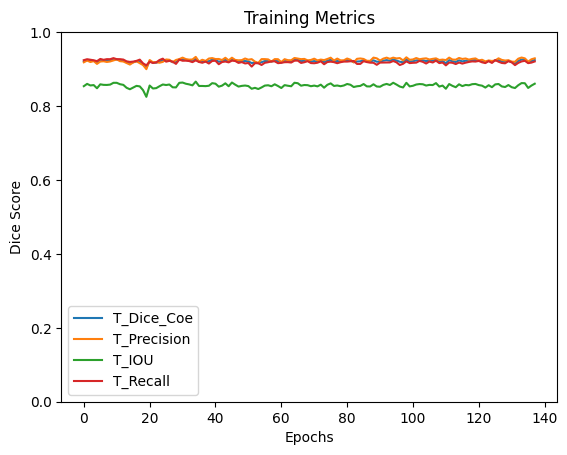

In [131]:
plt.plot(train_dice_val, label='T_Dice_Coe')
plt.plot(train_precision_val, label='T_Precision')
plt.plot(train_iou_val, label='T_IOU')
plt.plot(train_recall_val, label='T_Recall')
plt.title('Training Metrics')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

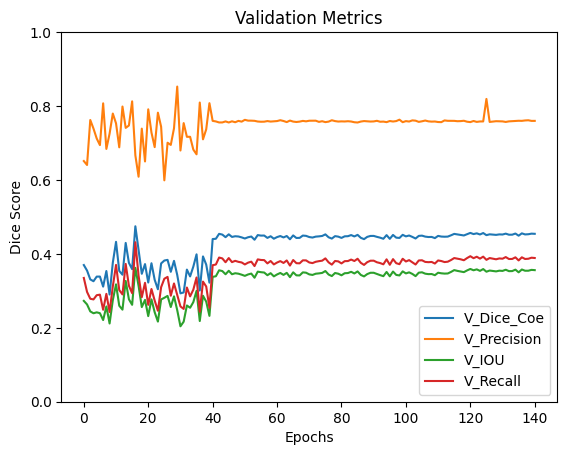

In [130]:
plt.plot(val_dice_val, label='V_Dice_Coe')
plt.plot(val_precision_val, label='V_Precision')
plt.plot(val_iou_val, label='V_IOU')
plt.plot(val_recall_val, label='V_Recall')
# plt.plot(val_precision_val)
# plt.plot(val_iou_val)
# plt.plot(val_recall_val)
plt.title('Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [122]:
old_history_val = history_val
old_history_val

{'train_dice_coe': [tensor(0.9208, device='cuda:0'),
  tensor(0.9245, device='cuda:0'),
  tensor(0.9217, device='cuda:0'),
  tensor(0.9225, device='cuda:0'),
  tensor(0.9173, device='cuda:0'),
  tensor(0.9237, device='cuda:0'),
  tensor(0.9227, device='cuda:0'),
  tensor(0.9228, device='cuda:0'),
  tensor(0.9232, device='cuda:0'),
  tensor(0.9262, device='cuda:0'),
  tensor(0.9262, device='cuda:0'),
  tensor(0.9239, device='cuda:0'),
  tensor(0.9227, device='cuda:0'),
  tensor(0.9180, device='cuda:0'),
  tensor(0.9150, device='cuda:0'),
  tensor(0.9185, device='cuda:0'),
  tensor(0.9211, device='cuda:0'),
  tensor(0.9204, device='cuda:0'),
  tensor(0.9125, device='cuda:0'),
  tensor(0.9032, device='cuda:0'),
  tensor(0.9219, device='cuda:0'),
  tensor(0.9170, device='cuda:0'),
  tensor(0.9173, device='cuda:0'),
  tensor(0.9205, device='cuda:0'),
  tensor(0.9235, device='cuda:0')],
 'val_dice_coe': [tensor(0.3698, device='cuda:0'),
  tensor(0.3548, device='cuda:0'),
  tensor(0.3310, dev

In [103]:
mask_one = Image.open(train_image_path + "0.png")
mask_one

NameError: name 'train_image_path' is not defined

tensor(0.2041, device='cuda:0')
torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
1.0 86.0 1.0 164.0
tensor(0.6560, device='cuda:0')


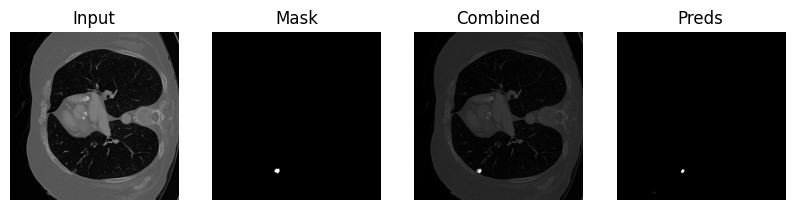

In [132]:
with torch.no_grad():
    model.eval()
    
    x = torch.tensor(np.array(Image.open(TRAIN_IMG_PATH + "/"+str(i) +".png").convert("L"), dtype=np.float32)).to(device=DEVICE) / 255
    y = torch.tensor(np.array(Image.open(TRAIN_MASK_PATH + "/"+str(i) +".png").convert("L"), dtype=np.float32)).to(device=DEVICE) / 255
#     x = (x > x.mean()*1.5) * x
    print(x.mean())
    x = x.reshape(1, 1, 512, 512)
    y = y.reshape(1, 1, 512, 512)
    print(x.shape, y.shape)
    preds = torch.sigmoid(model(x))
    preds = (preds > 0.5).float()
    
    fig = plt.figure(figsize=(10, 20)) 
    
    fig.add_subplot(1, 4, 1)
    plt.imshow(x[0].cpu().T, cmap='gray')
    plt.axis('off')
    plt.title('Input')
              
    fig.add_subplot(1, 4, 2)
    plt.imshow(y[0].cpu().T, cmap='gray')
    plt.axis('off')
    plt.title('Mask')
    
    fig.add_subplot(1, 4, 3)
    plt.imshow((x+y+preds)[0].cpu().T, cmap='gray')
    plt.axis('off')
    plt.title('Combined')
    
    
    fig.add_subplot(1, 4, 4)
    plt.imshow(preds[0].cpu().T, cmap='gray')
    plt.axis('off')
    plt.title('Preds')
    print(preds[0].max().item(), preds[0].sum().item(), y[0].max().item(), y[0].sum().item())
    print((2 * (preds * y).sum() + 1e-8) / ((preds + y).sum() + 1e-8))
    
    

##### x = torch.randn((3,1, 160, 160))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
print(preds.shape)
print(x.shape)
assert preds.shape == x.shape

/tmp/ipykernel_34/842951527.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15, 30))


tensor(0.3919, device='cuda:0')


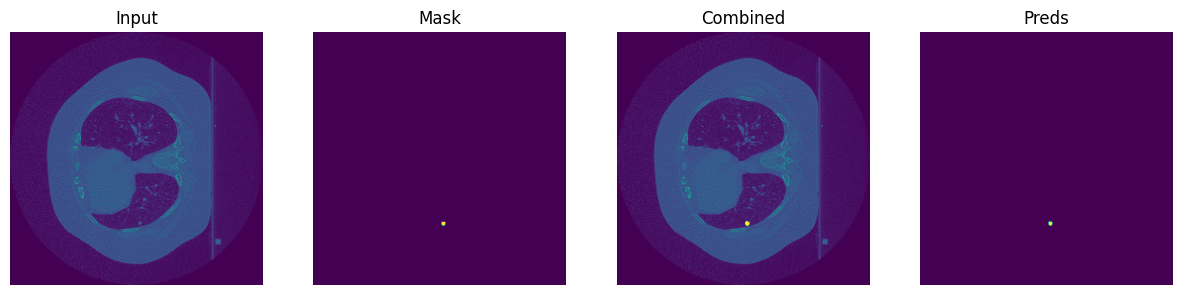

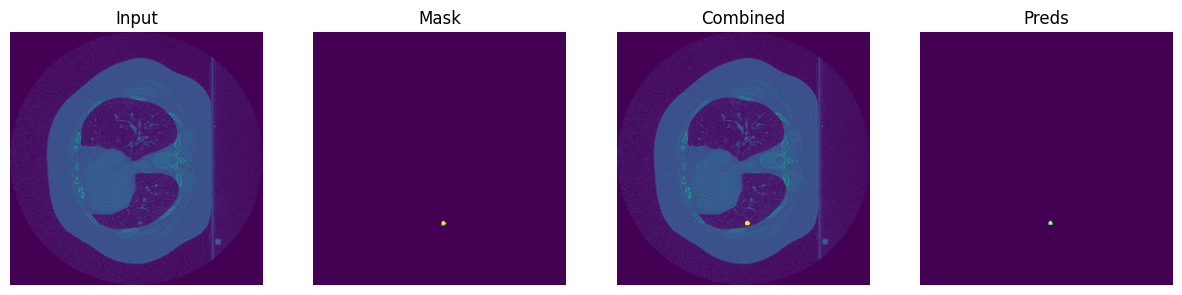

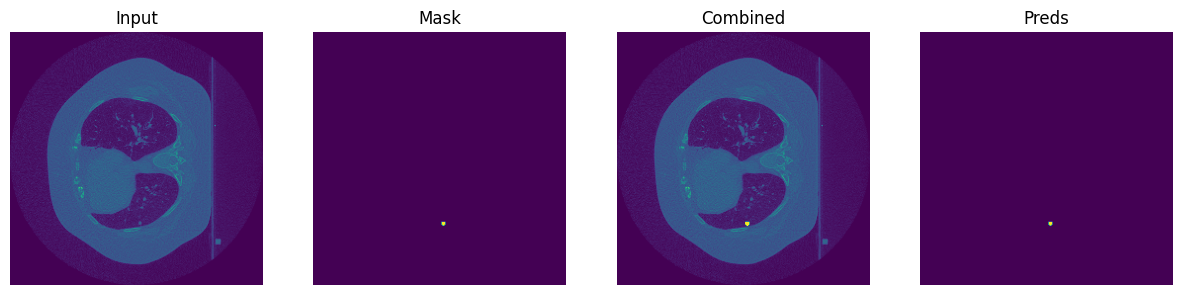

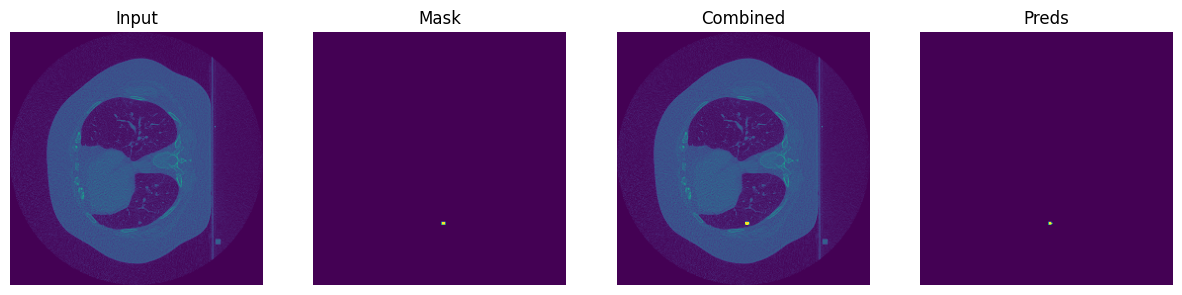

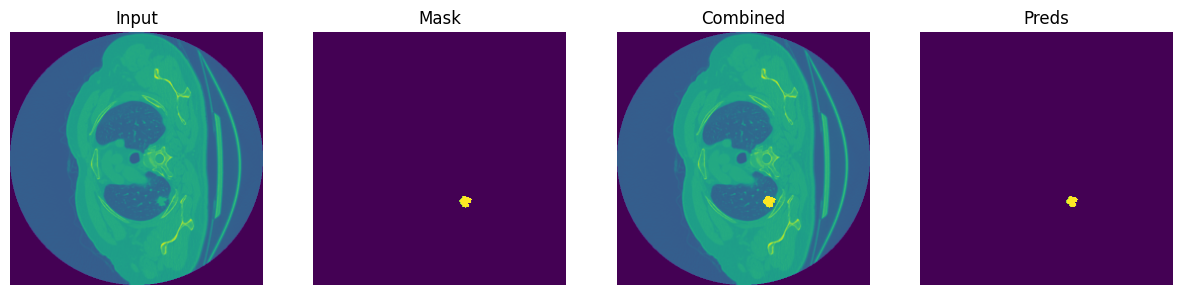

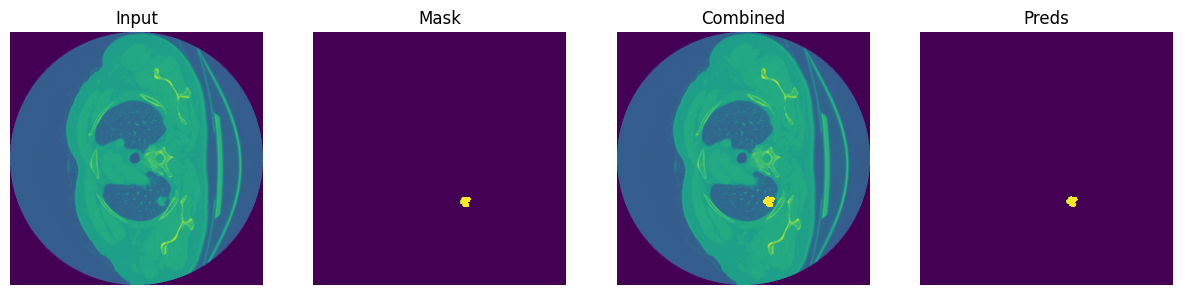

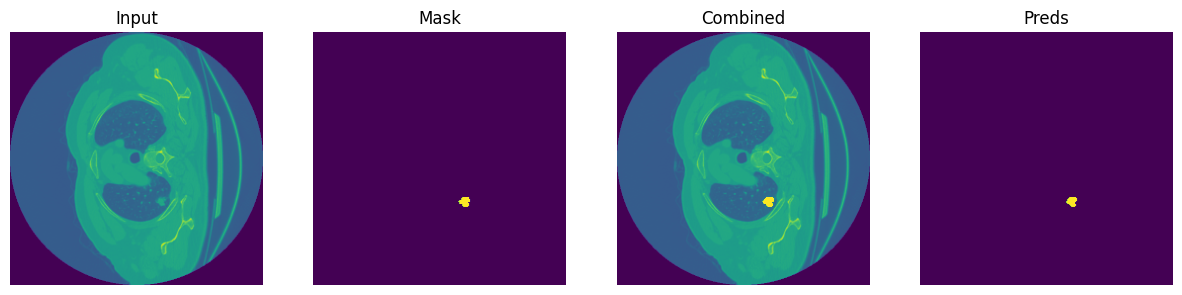

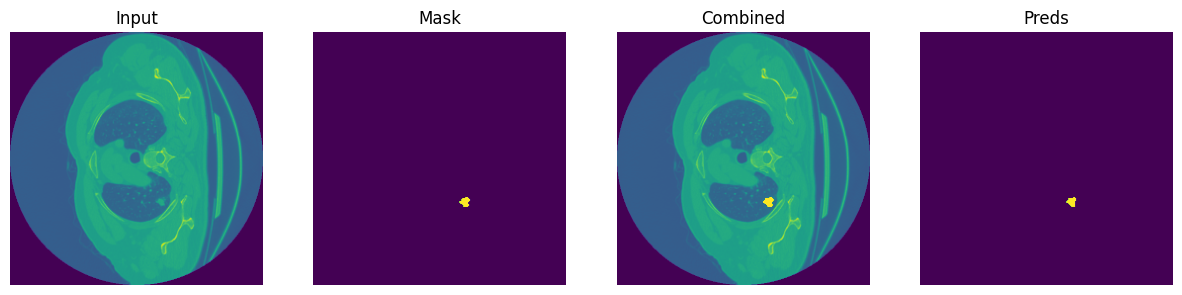

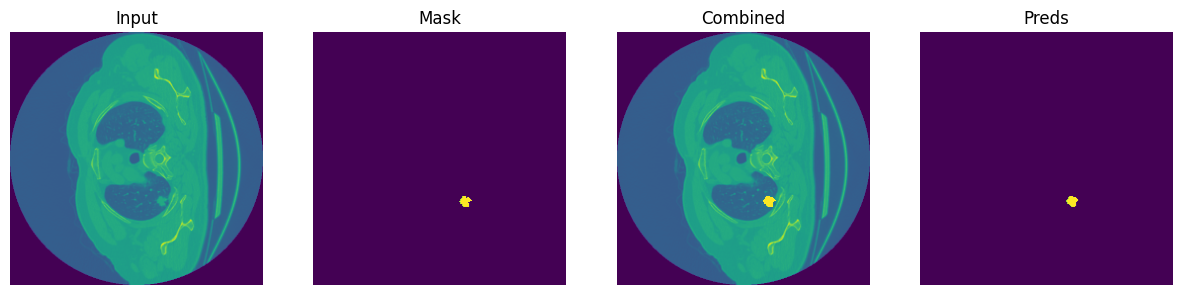

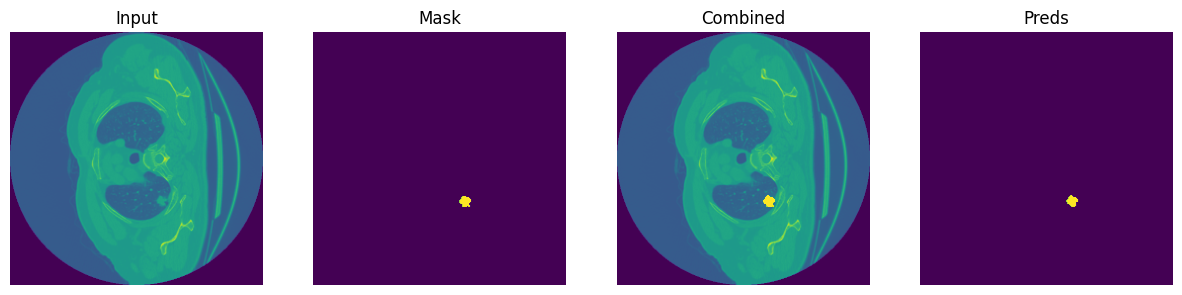

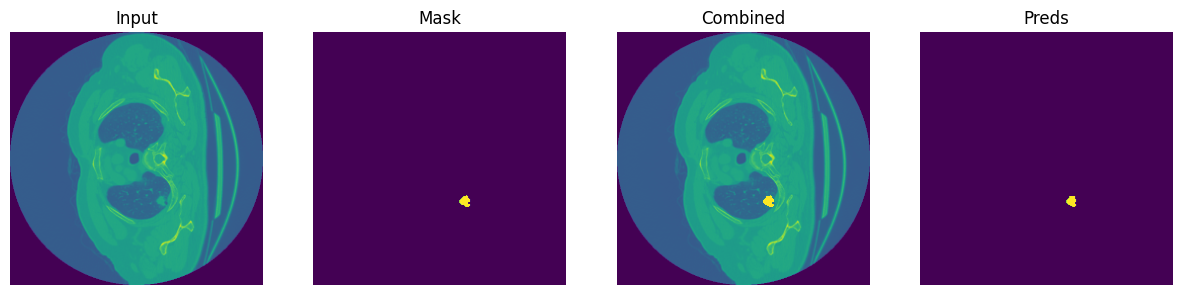

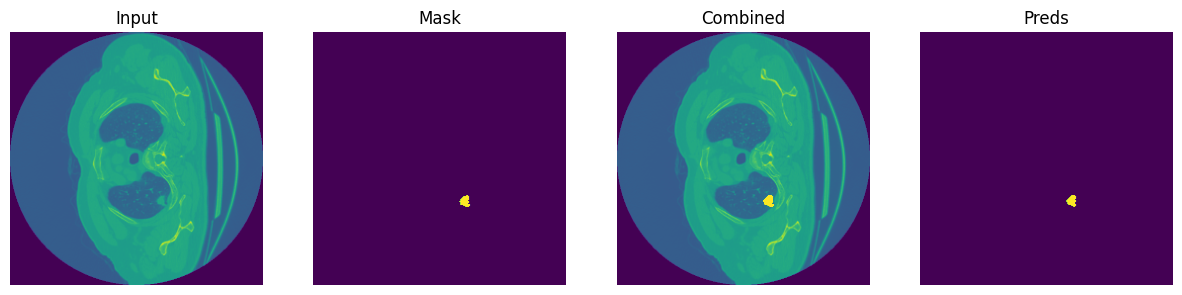

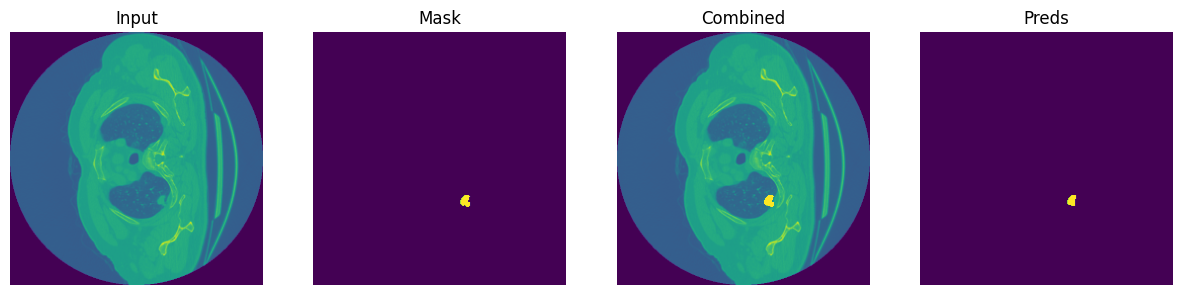

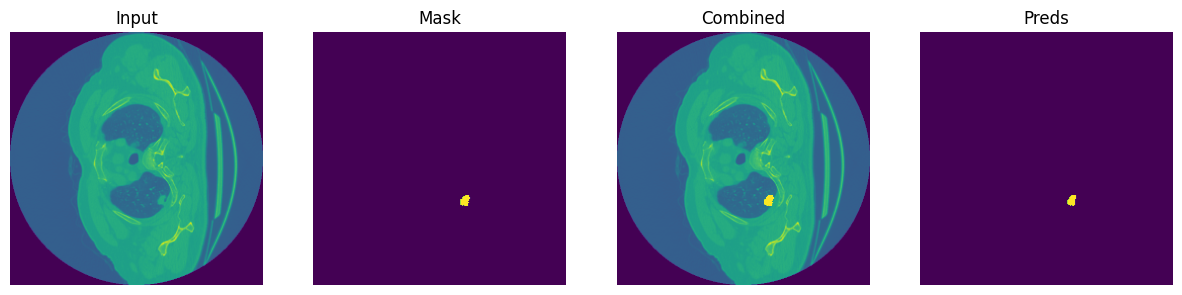

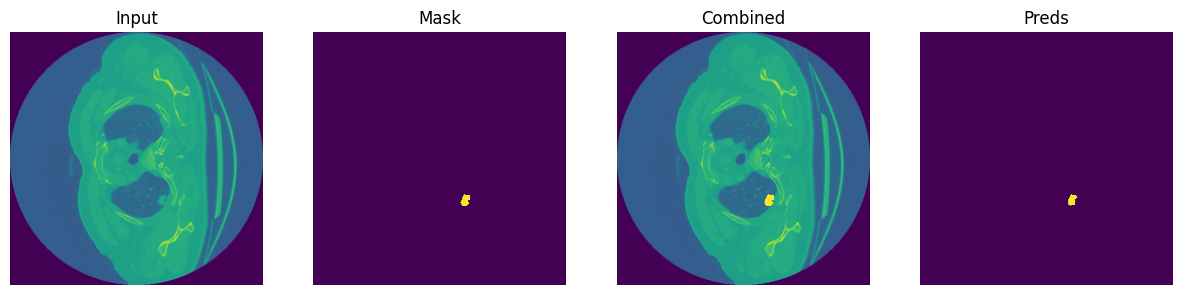

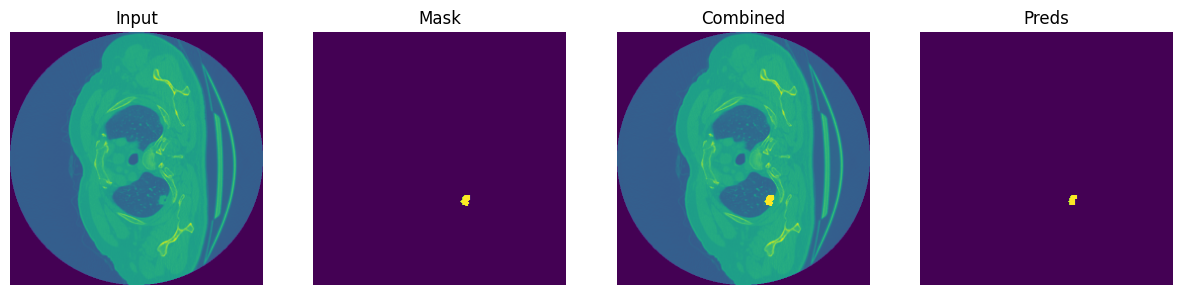

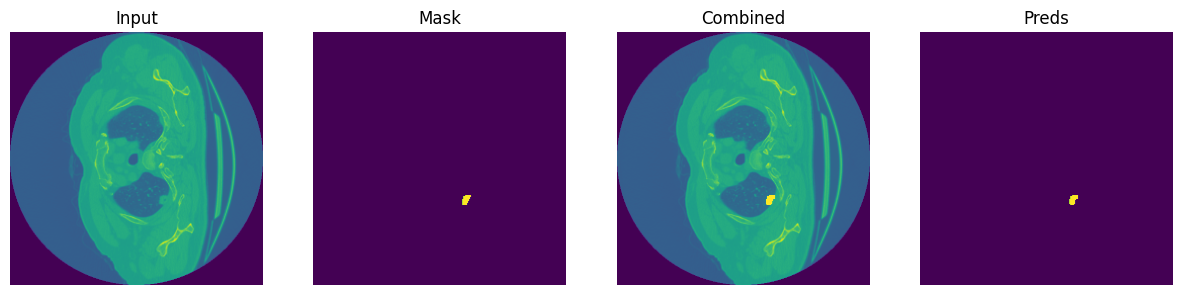

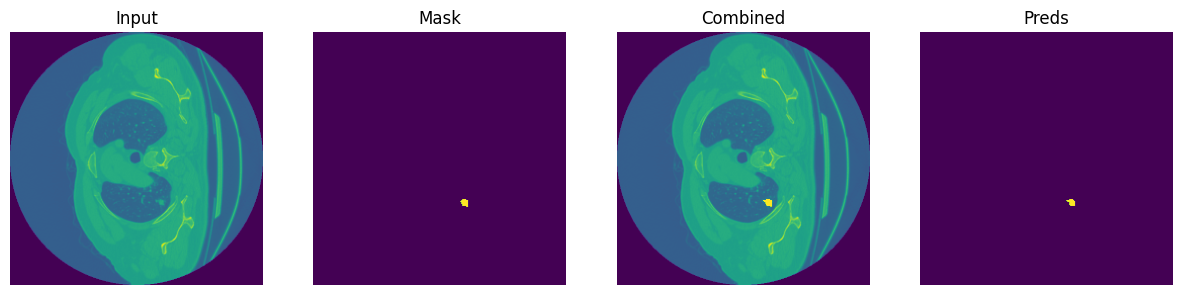

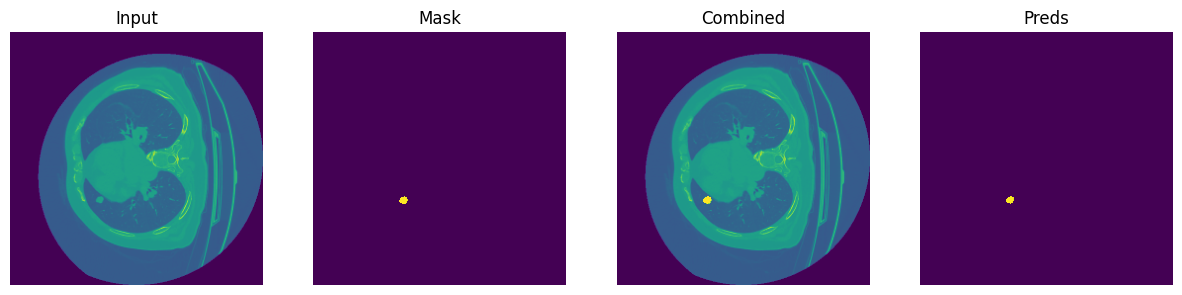

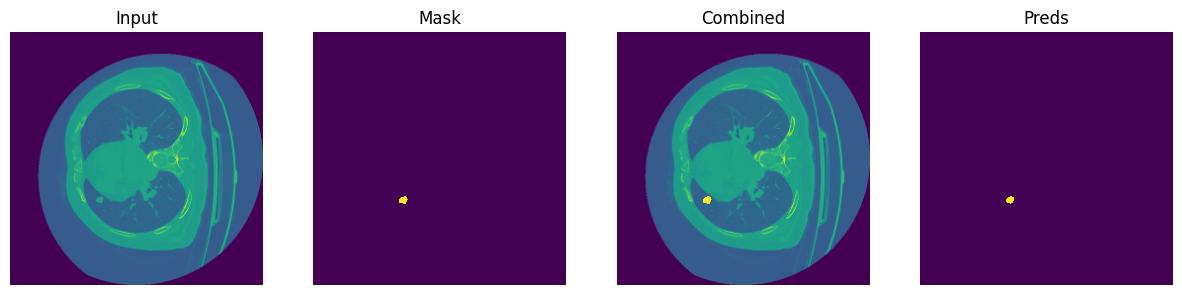

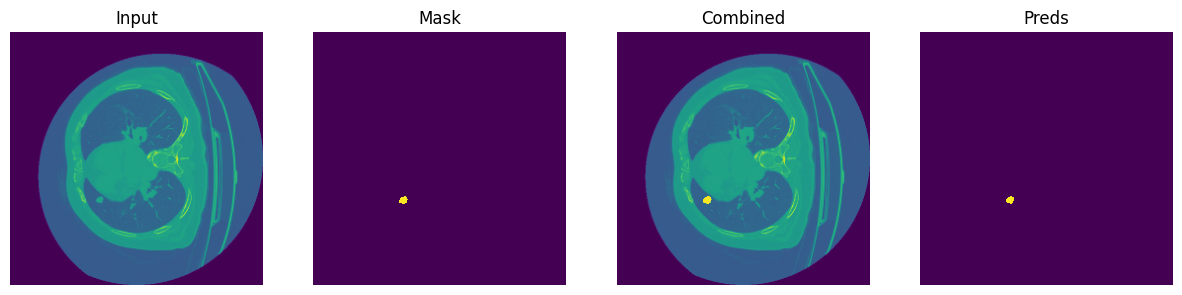

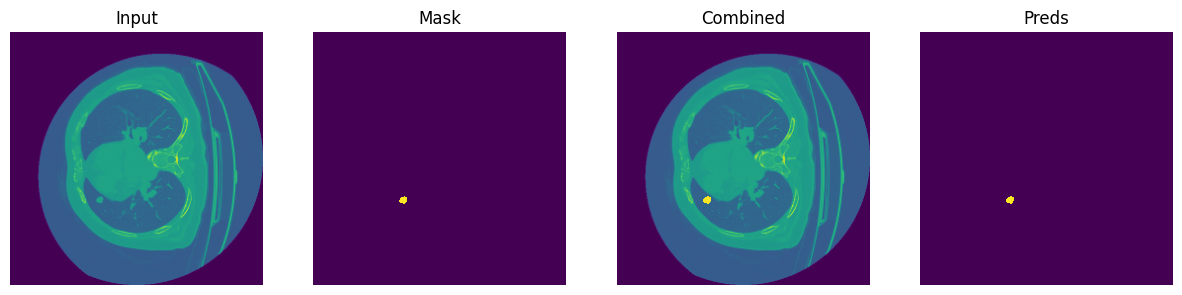

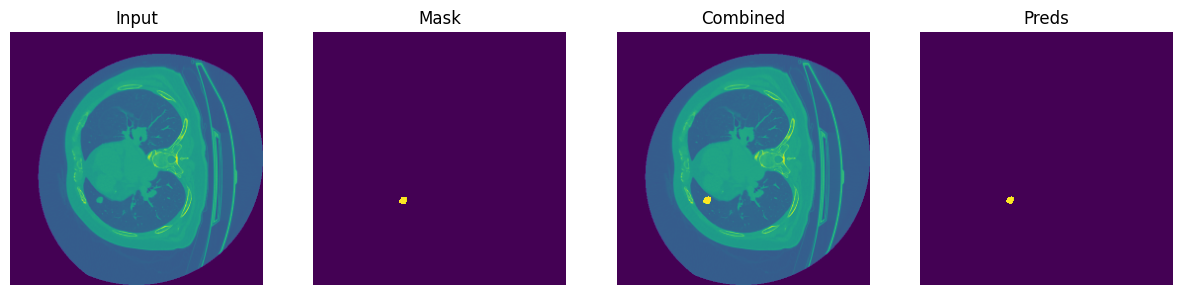

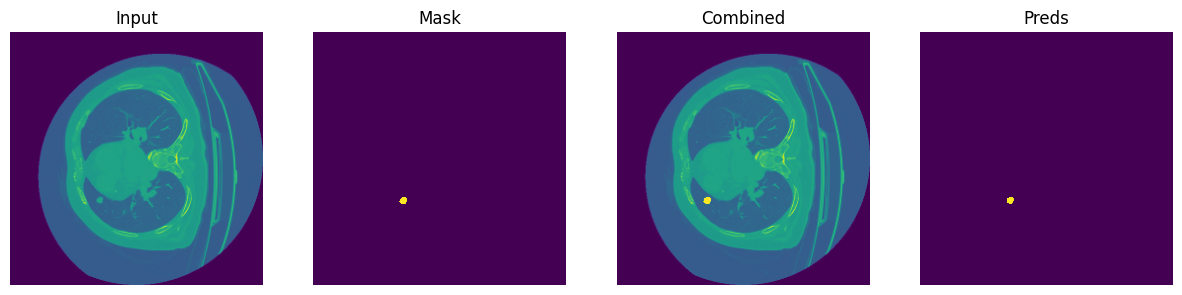

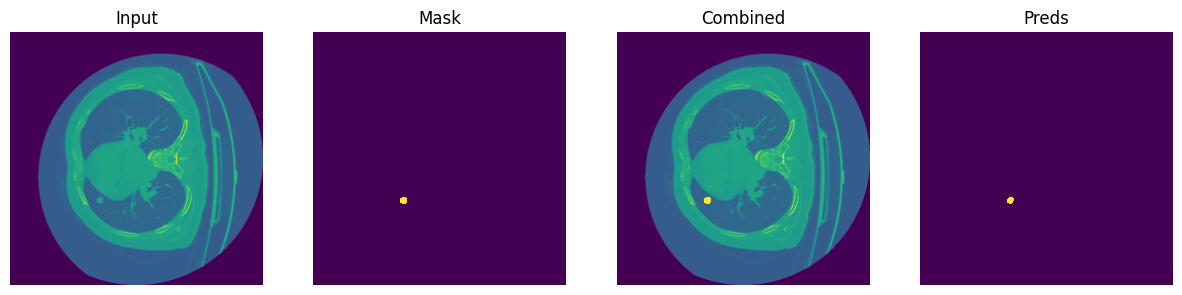

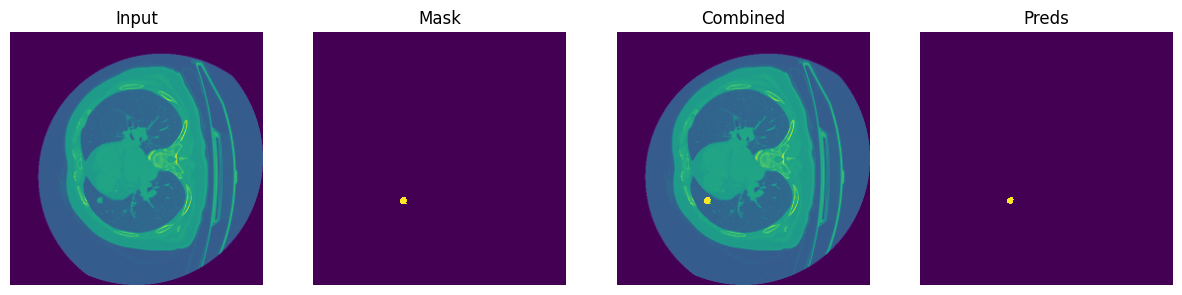

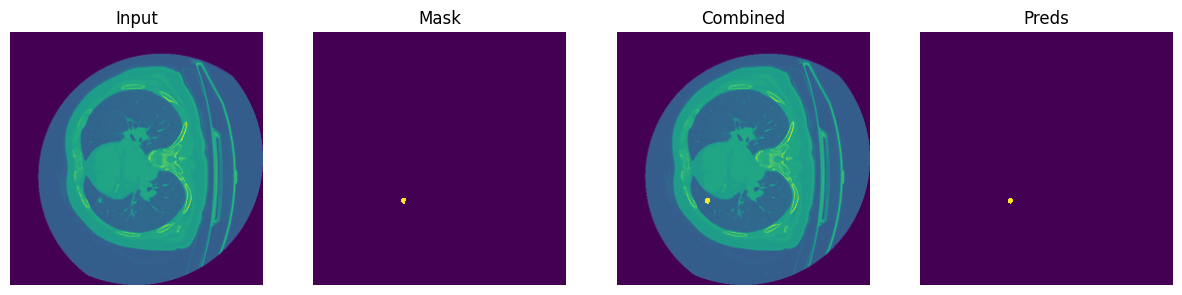

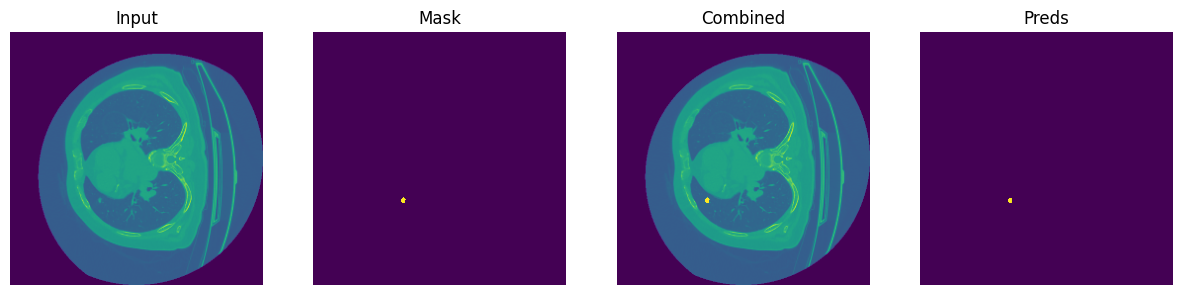

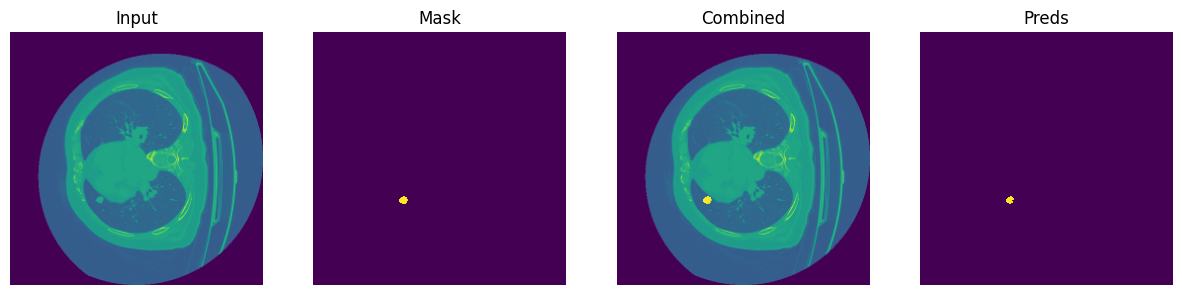

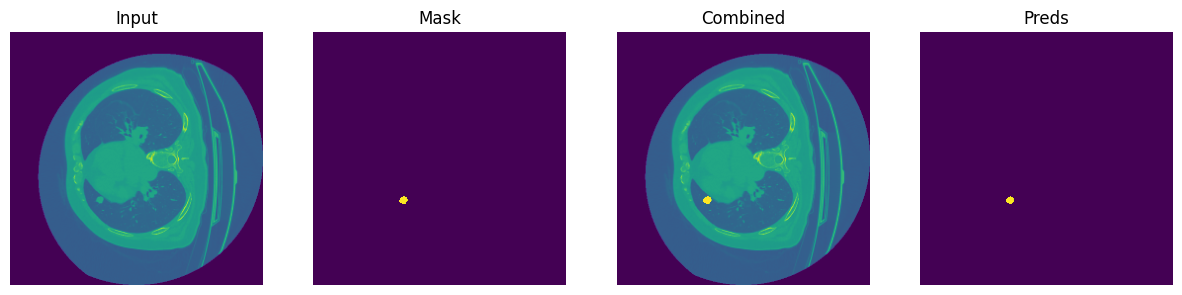

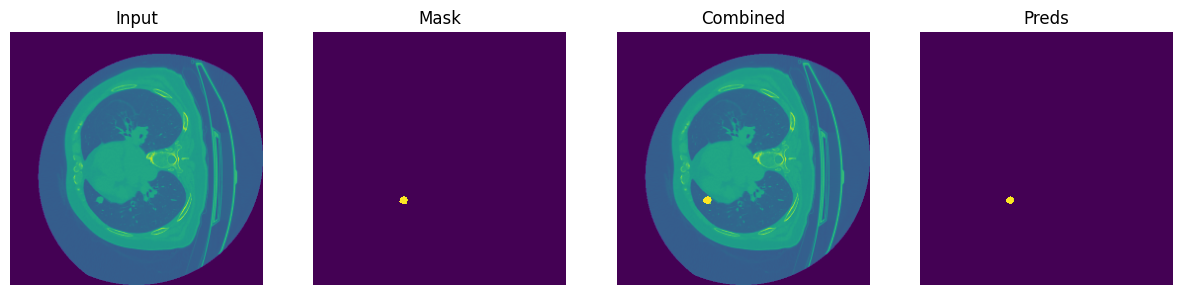

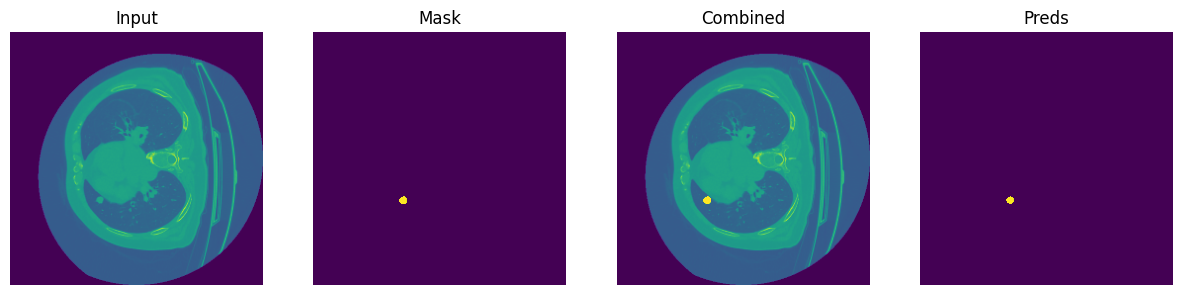

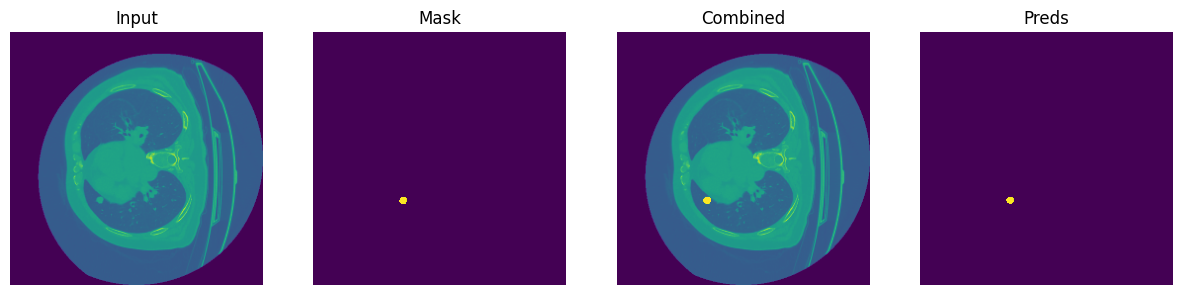

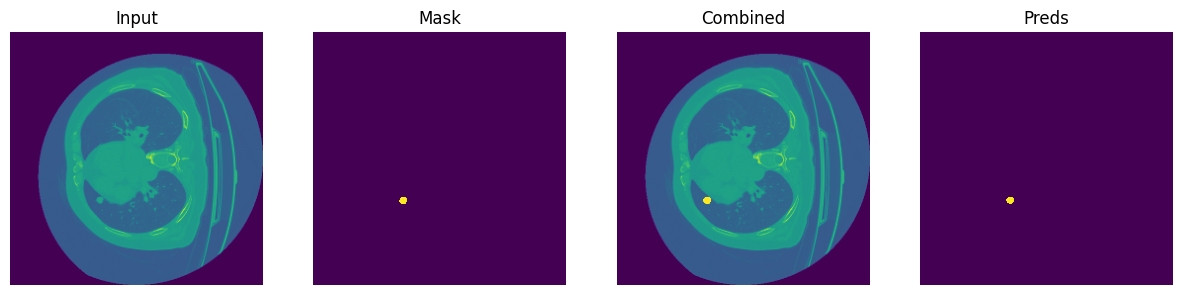

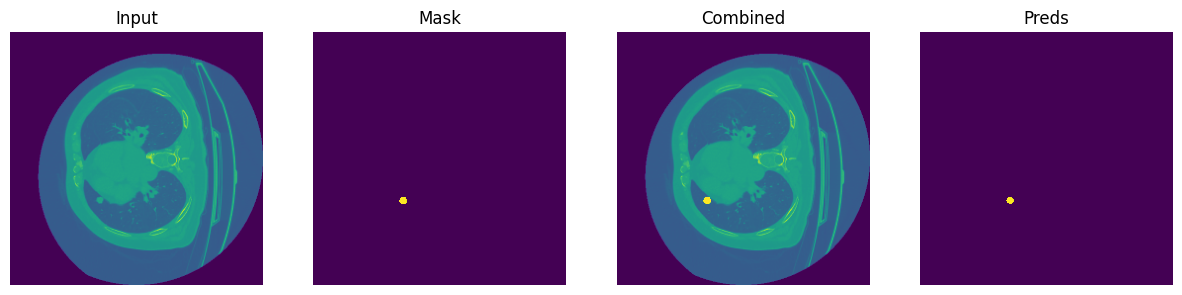

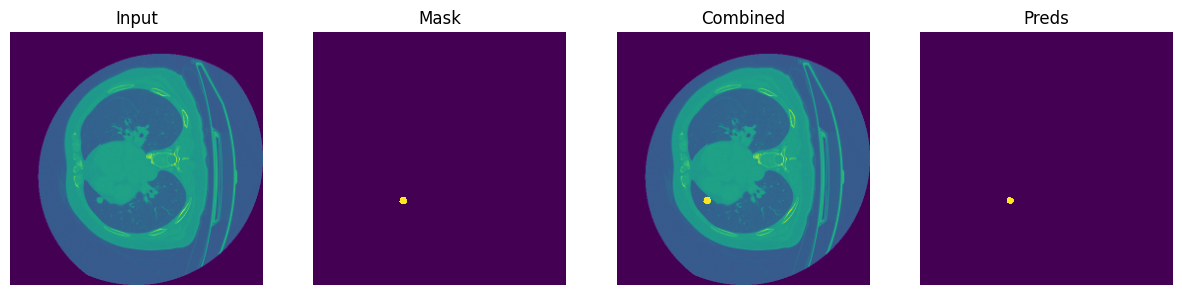

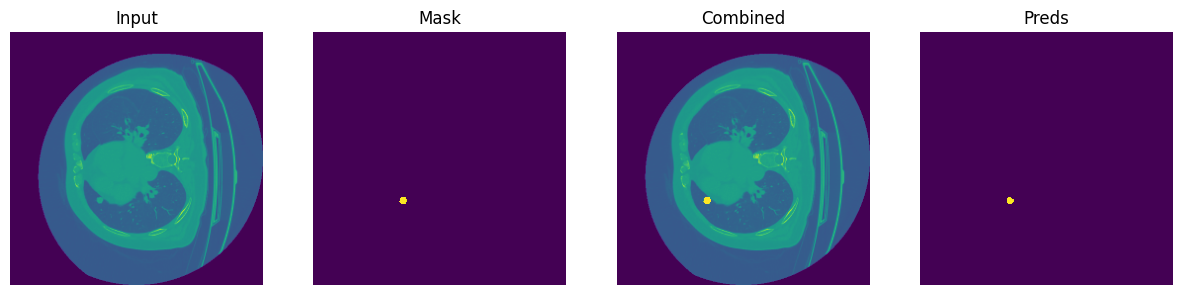

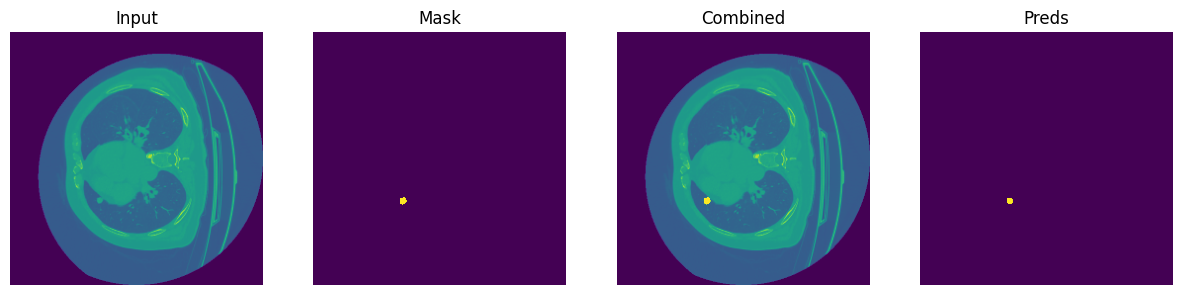

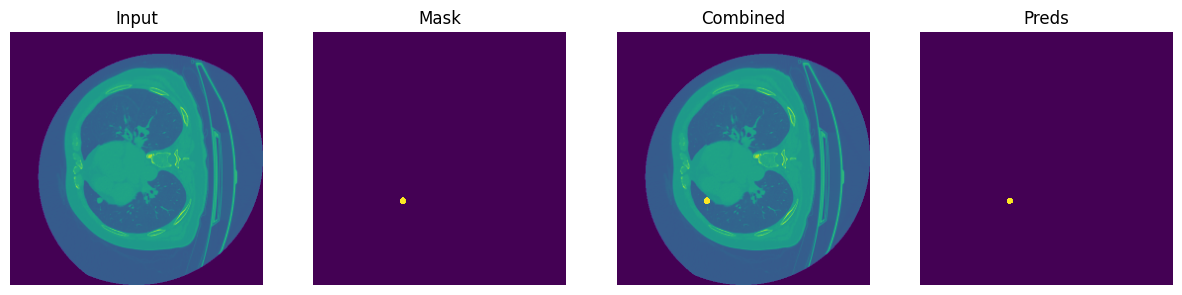

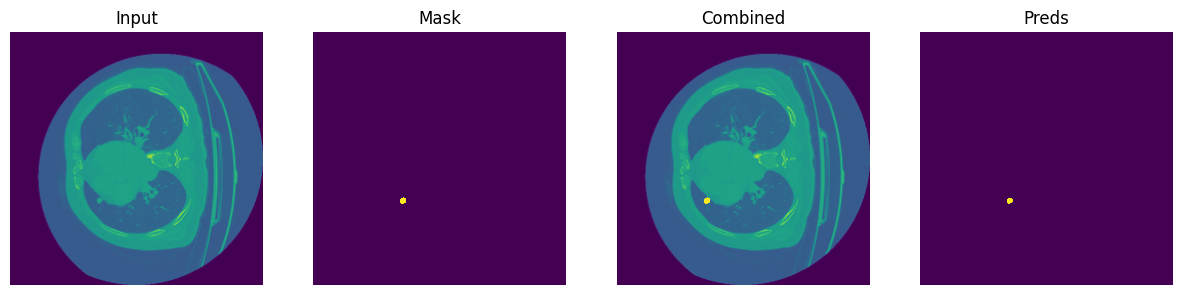

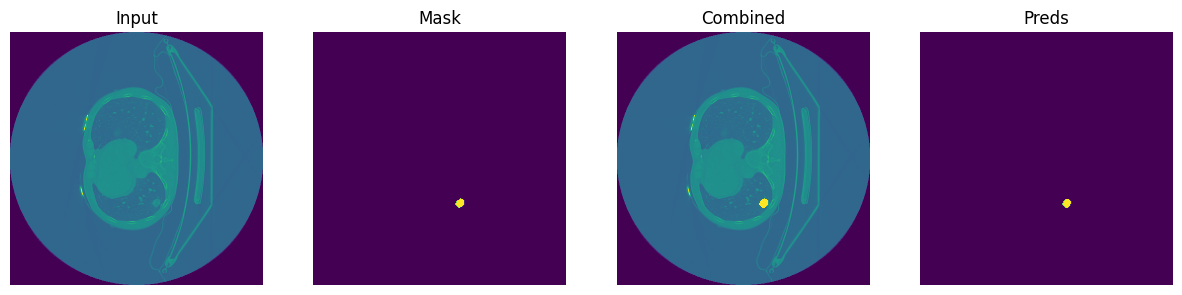

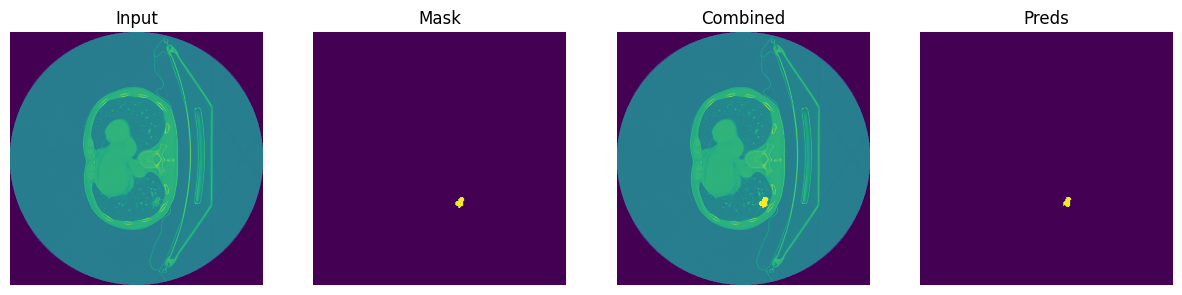

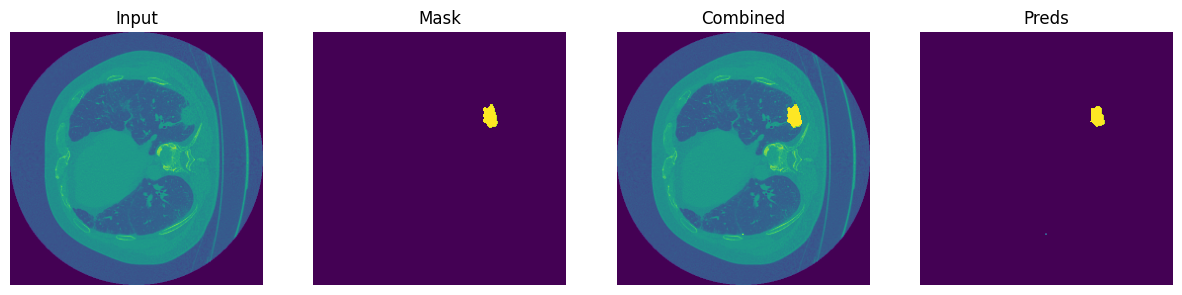

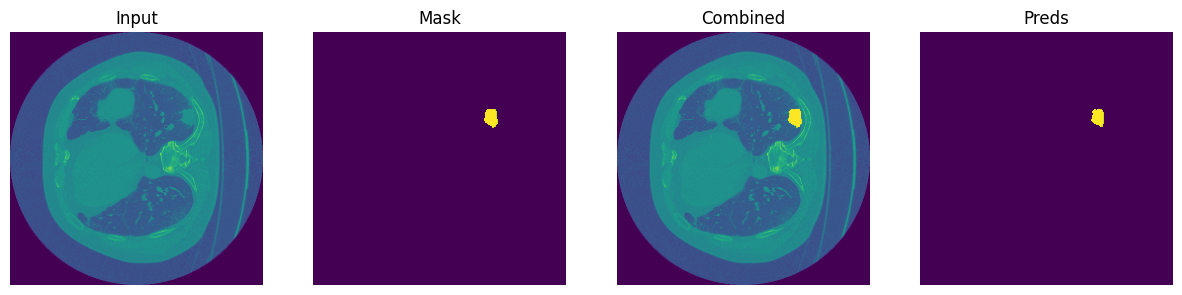

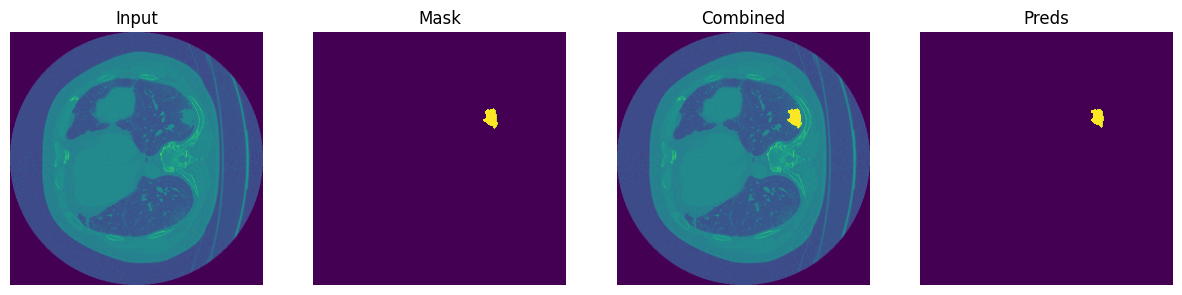

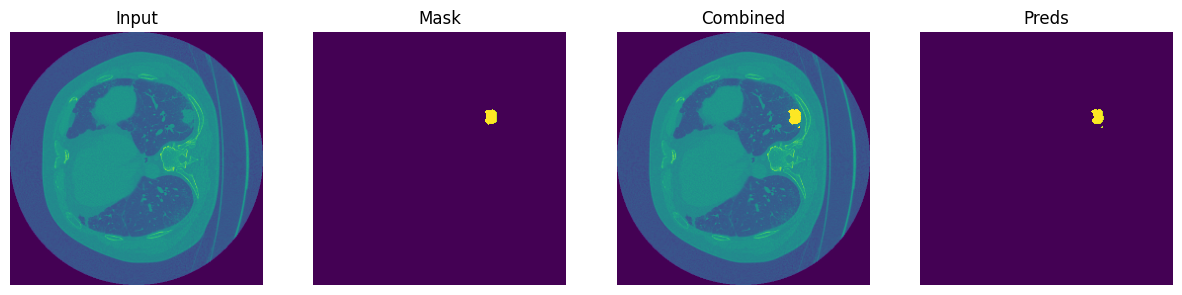

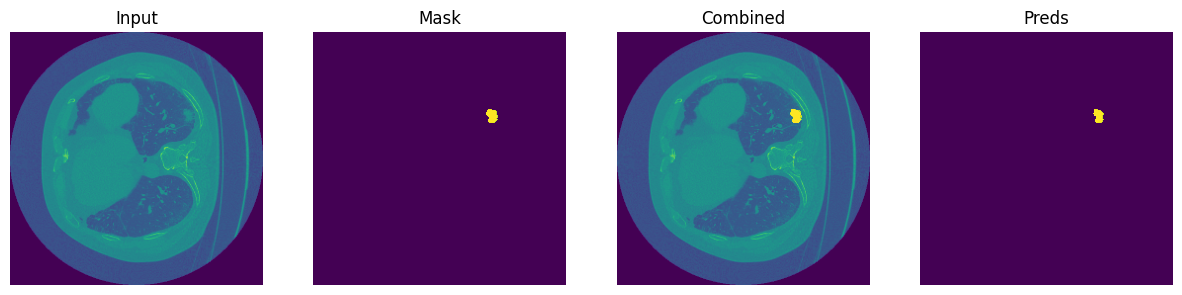

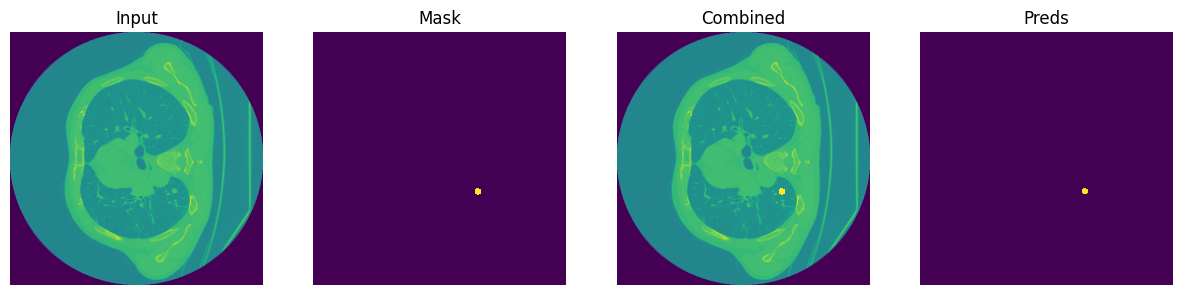

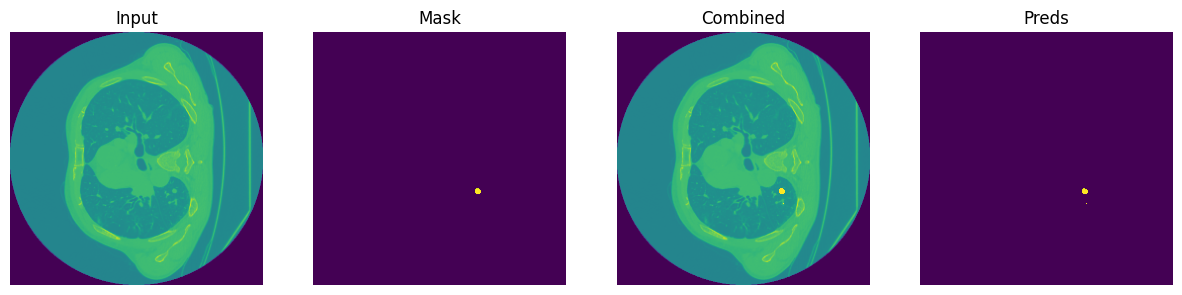

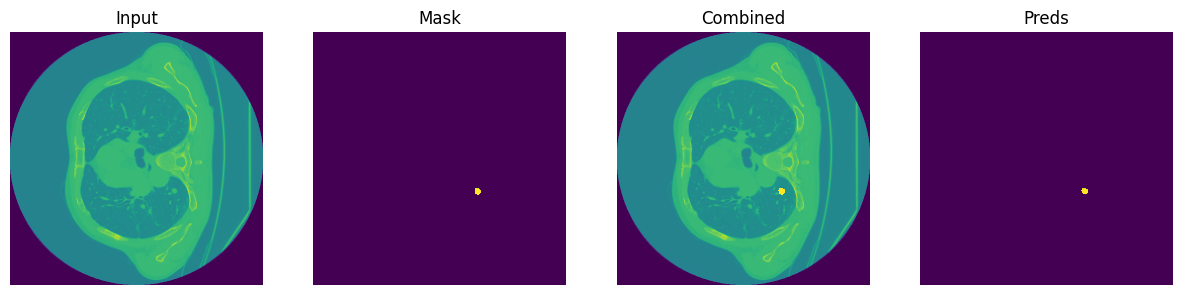

In [152]:
tl, vl = get_loaders(
    TRAIN_IMG_PATH,
    TRAIN_MASK_PATH,
    TEST_IMG_PATH,
    TEST_MASK_PATH,
    1,
    train_transform,
    val_transform
)
count = {'0.0':0, '1.0':0, '2.0':0, '3.0':0, '4.0':0, '5.0':0, '6.0':0, '7.0':0, '8.0':0}
with torch.no_grad():
    model.eval()
    dice_score = 0
    for data, target in vl:
        data = data.to(device=DEVICE)
        target = target.float().unsqueeze(1).to(device=DEVICE)

        predictions = model(data)
        preds = torch.sigmoid(predictions)
        preds = (preds > 0.5).float()
        
        cur_dice_score = (2 * (preds * target).sum() + 1e-8) / ((preds + target).sum() + 1e-8)
        
        if cur_dice_score.item() > 0.90:
            fig = plt.figure(figsize=(15, 30)) 

            fig.add_subplot(1, 4, 1)
            plt.imshow(data[0].cpu().T,vmin=0, vmax=1)
            plt.axis('off')
            plt.title('Input')

            fig.add_subplot(1, 4, 2)
            plt.imshow(target[0].cpu().T)
            plt.axis('off')
            plt.title('Mask')

            fig.add_subplot(1, 4, 3)
            plt.imshow((data*4+target*2+preds*4)[0].cpu().T, vmin=0, vmax=4)
            plt.axis('off')
            plt.title('Combined')


            fig.add_subplot(1, 4, 4)
            plt.imshow(preds[0].cpu().T)
            plt.axis('off')
            plt.title('Preds')
            
#         print(preds[0].max().item(), preds[0].sum().item(), y[0].max().item(), y[0].sum().item())
            tumor_size = target.sum().item()
            if tumor_size >= 800:
                count['8.0'] += 1
            else:
                idx = str(tumor_size // 100)
                count[idx] += 1
        dice_score += cur_dice_score
    print(dice_score / 264)
#     plt.imshow(x.cpu())
#     plt.axis('off')
#     plt.title('Input')
    
    

In [91]:
count

{'0.0': 159,
 '1.0': 0,
 '2.0': 0,
 '3.0': 0,
 '4.0': 0,
 '5.0': 0,
 '6.0': 0,
 '7.0': 0,
 '8.0': 0}

/tmp/ipykernel_34/4218296395.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3614.)
  axarr[0].imshow(x[0].T)


<Figure size 640x480 with 0 Axes>

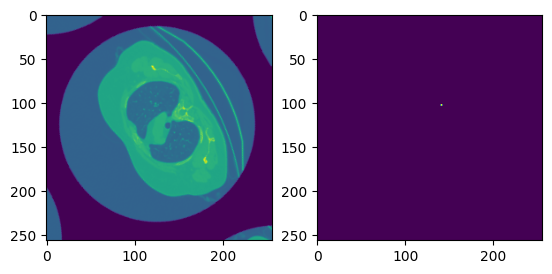

In [25]:
table = {'0': 0, '1': 0}
for x, y in train_loader:
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x[0].T)
    axarr[1].imshow(y[0].T)
    break

In [44]:
def recall_score_(groundtruth_mask, pred_mask):
    intersect = (pred_mask*groundtruth_mask).sum()
    total_pixel_truth = (groundtruth_mask).sum()
    recall = (intersect/total_pixel_truth)
    return recall 

In [77]:
avg_a = 0
avg_b = 0
avg_c = 0
for x, y in train_loader:
    
    with torch.no_grad():
        x = x.to(device=DEVICE)
        y = y.to(device=DEVICE)
        
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
        preds_sq = preds.squeeze(1)
#         print(preds.shape, preds_sq.shape)
#         plt.imshow(preds.cpu()[0].T)
        TP = ((y.cpu() == 1) * (preds_sq.cpu() == 1)).sum()
        TN = ((y.cpu() == 0) * (preds_sq.cpu() == 0)).sum()
        FP = ((y.cpu() == 0) * (preds_sq.cpu() == 1)).sum()
        FN = ((y.cpu() == 1) * (preds_sq.cpu() == 0)).sum()
#         recall_val = recall_score_(y, preds)
#         0.0016678
#         2 * 371 / (2 * 371 + 367056 + 642) = 742 / 368840 = 0.00201
#         print((preds * y).shape, (preds * y).sum(), (preds + y).shape, (preds + y).sum())
        
        dice_score = (2 * (preds * y).sum() + 1e-8) / ((preds + y).sum() + 1e-8)
        dice_score_a = (2 * TP) / (2 * TP + FP + FN)
        p = dice_score/dice_score_a
        print(dice_score, dice_score_a, p)
        avg_a += dice_score
        avg_b += dice_score_a
        avg_c += p
print(avg_a.item()/len(train_loader), avg_b.item()/len(train_loader), avg_c.item()/len(train_loader))
#         print(x.shape, preds.shape,  y.shape, recall_val, TP, TN, FP, FN, sum([TP, TN, FP, FN]))
#     break

tensor(0.0021, device='cuda:0') tensor(0.0021) tensor(1.0079, device='cuda:0')
tensor(0.0018, device='cuda:0') tensor(0.0025) tensor(0.7352, device='cuda:0')
tensor(0.0020, device='cuda:0') tensor(0.0029) tensor(0.7063, device='cuda:0')
tensor(0.0022, device='cuda:0') tensor(0.0028) tensor(0.7846, device='cuda:0')
tensor(0.0035, device='cuda:0') tensor(0.0035) tensor(0.9960, device='cuda:0')
tensor(0.0024, device='cuda:0') tensor(0.0020) tensor(1.2021, device='cuda:0')
tensor(0.0016, device='cuda:0') tensor(0.0022) tensor(0.7129, device='cuda:0')
tensor(0.0036, device='cuda:0') tensor(0.0041) tensor(0.8601, device='cuda:0')
tensor(0.0039, device='cuda:0') tensor(0.0058) tensor(0.6827, device='cuda:0')
tensor(0.0020, device='cuda:0') tensor(0.0019) tensor(1.0607, device='cuda:0')
tensor(0.0033, device='cuda:0') tensor(0.0033) tensor(1.0157, device='cuda:0')
tensor(0.0041, device='cuda:0') tensor(0.0058) tensor(0.7118, device='cuda:0')
tensor(0.0010, device='cuda:0') tensor(0.0010) tenso

Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))